In [3]:
import importlib
import ubx_parser
from matplotlib import pyplot as plt
import importer
import math
from pyproj import Proj
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from geopy.distance import great_circle
import utils
from scipy.signal import butter,filtfilt



In [4]:
# Here, the derivation of acceleration and deceleration maneuvers is shown (cf. thesis 3.2.3)
# Note, that the code in the "productive env" (db_importer) was modified. However, the basic idea is the same.
# This notebook and especially the plots might help to understand what is derived. 

importlib.reload(importer)


path = 'simra_records/'

dfs = importer.import_files(path)
mi9_1 = importer.preprocess_basics(dfs[2], True)
a2_1 = importer.preprocess_basics(dfs[0], True)

mi9_2 = importer.preprocess_basics(dfs[1], True)
a2_2 = importer.preprocess_basics(dfs[3], True)

 50%|█████     | 2/4 [00:00<00:00,  4.21it/s]

simra_records/A2_1_jacket 0
simra_records/Mi9_2_jacket 1


100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

simra_records/Mi9_1_jacket 2
simra_records/A2_2_jacket 3


1.0414853908992663 0.5207426954496331
1.8676004048754853 0.9338002024377426
0.7504937436641524 0.3752468718320762
0.9116694523767316 0.4558347261883658


In [5]:
def insert_empty_rows(df):
    data = df.values
    for i in range(4):
        nans = np.where(np.empty_like(data), np.nan, np.nan)
        data = np.hstack([nans, data])
    return pd.DataFrame(data.reshape(-1, df.shape[1]), columns=df.columns)


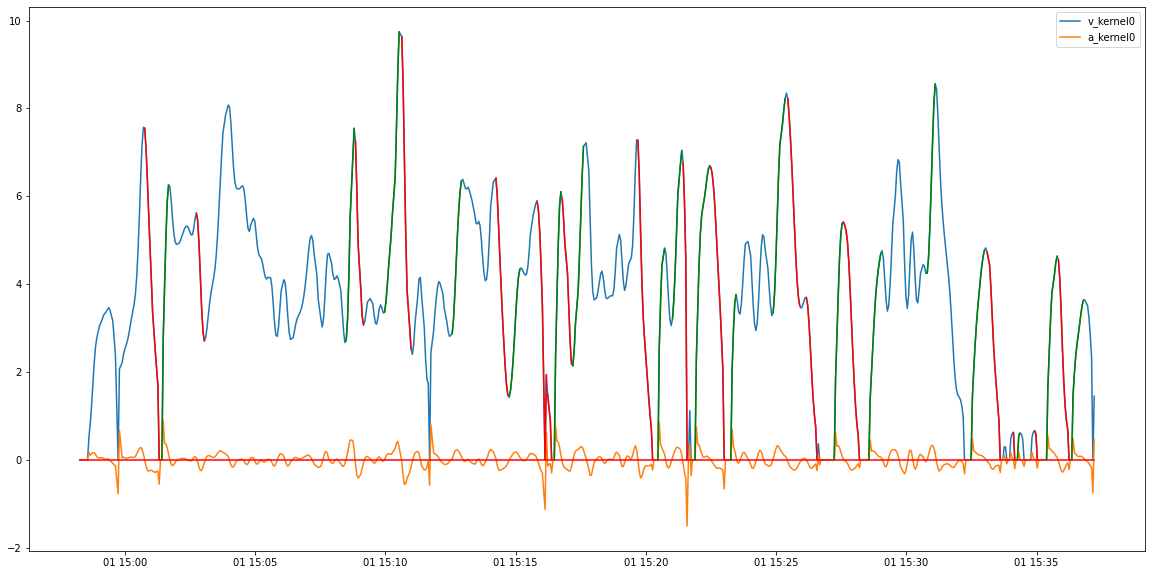

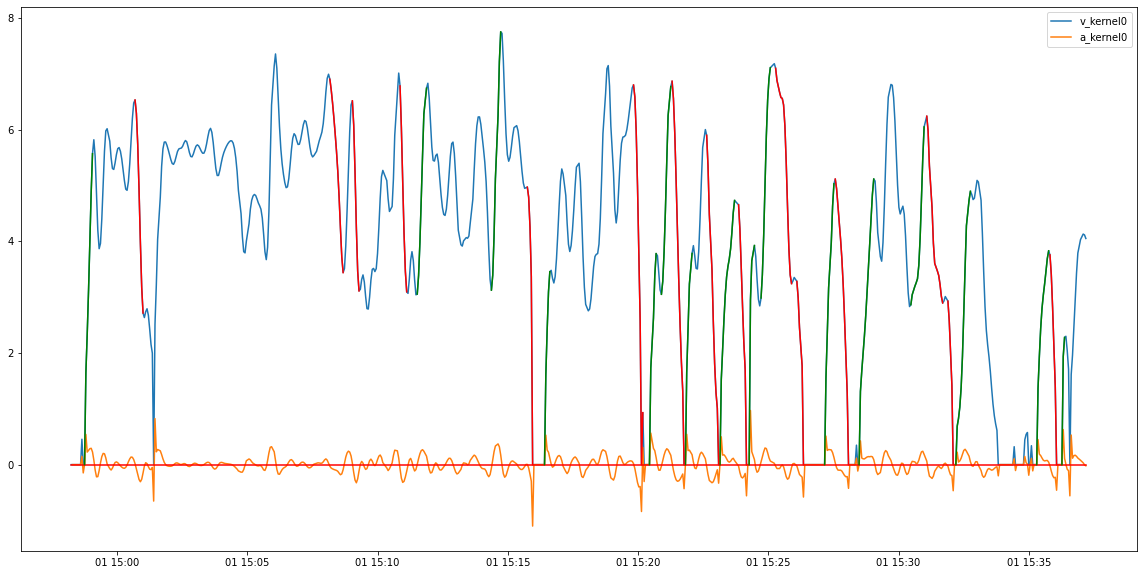

In [6]:
# Result plot shows valid acceleration (green) and deceleration (red) maneuvers. 

data_sources = [a2_1, mi9_1]

# Filters are applied to Velocity and acceleration. Parameterization of filters is arbitrary. 
# Here, merely the actual mechanics of the derivations are presented. The mechanics are then used inside db_importer.
v_filter = 'velo_k0'
a_filter = 'a_k'


for ds in data_sources:
    ds = ds[ds['section'] >= 0]
    tmp = ds.copy()
    
    threshold = 0.5
    win_type = 'gaussian'
    if v_filter is 'velo_k':
        window_size = 15
        std = 1.7
        tmp[v_filter] = tmp.velo.rolling(window=window_size, win_type=win_type, center=True, min_periods=1).mean(std=std)
    else:
        window_size = 17
        std = 2.0
        tmp[v_filter] = np.where(tmp.velo < threshold, 0, tmp.velo.rolling(window=window_size, win_type=win_type, center=True, min_periods=1).mean(std=std))
    ds[v_filter] = tmp[v_filter]
    ds[a_filter] = (ds[v_filter] - ds.shift(1)[v_filter]) / ds['duration']
    
    tmp = insert_empty_rows(ds).copy()
    tmp_ak = tmp[['date', a_filter]].copy()
    
    
    ## es werden empty rows reingebuffert, damit die Auflösung von a erhöht werden kann (über interpolate). 
    ## So lassen sich values nahe 0 finden. Bei 1/3Hz Auflösung gelingt das bei zu wenigen.
    df = tmp_ak.copy()

    t0 = tmp_ak['date'].min()
    m = tmp_ak['date'].notnull()
    tmp_ak.loc[m, 't_int'] = (tmp_ak.loc[m, 'date'] - t0).dt.total_seconds()
    tmp_ak['date'] = t0 + pd.to_timedelta(tmp_ak.t_int.interpolate(), unit='s')

    tmp_ak = tmp_ak[~tmp_ak.date.isnull()]
    tmp_ak[a_filter] = tmp_ak[a_filter].astype('float64').interpolate()

    th = 0.005
    extrema = tmp_ak[tmp_ak[a_filter].between(-th, th)].date.values
    
    ds = ds.set_index('date')
    segments = []
    for i in range(len(extrema)):
        if i+1 == len(extrema):
            break
        e1 = extrema[i]
        e2 = extrema[i+1]
        segments.append(ds[ds.index.get_loc(e1, method='nearest'):ds.index.get_loc(e2, method='nearest')])

        
    accels = []
    decels = []
    for s in segments:
        if len(s) < 1:
            continue
        if s.dist.cumsum().iloc[-1] < 5:
            continue
        if (s.duration.cumsum().iloc[-1] < 5) | (s.duration.cumsum().iloc[-1] > 40):
            continue

        initial_speed = s[v_filter].iloc[0]
        final_speed = s[v_filter].iloc[-1]
        t = abs(initial_speed - final_speed) / max(initial_speed, final_speed)
        if t < 0.5:
            continue


        if final_speed > initial_speed:
            ## hier < x, da es vorkommen kann, dass an den Grenzen des Segments marginal negative values vorkommen.
            if (s[a_filter] < -0.1).any():
                continue
            accels.append(s)
        else:
            if (s[a_filter][5:-5] > 0.1).any():
                continue
            decels.append(s)


    plt.figure(figsize=(20,10))

    f = 0
    t = -1

    
    plt.plot(ds.index[f:t], ds[v_filter][f:t], label='v_kernel0')
    plt.plot(ds.index[f:t], ds[a_filter][f:t], label='a_kernel0')

    plt.plot(ds.index[f:t], np.zeros(len(ds[a_filter][f:t])), color='r')

    extrema_indices=[]
    for e in extrema:
        extrema_indices.append(ds.index.get_loc(e, method='nearest'))
    
    
    #plt.scatter(extrema, ds.take(extrema_indices)[v_filter], marker=0, c='r')
    for s in accels:
        plt.plot(s.index,s[v_filter], color='g')

    for s in decels:
        plt.plot(s.index,s[v_filter], color='r')
    plt.savefig("images/accel_decel_maneuvers.png", bbox_inches='tight')

    plt.legend()
    